## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [50]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt

os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, njit, vectorize, cuda 
from numba import vectorize, int64, float64, int32, float32

In [13]:
@vectorize([float64(float64)], target='parallel', fastmath=True)

def vec_log(x):
    return np.log(x) 

@vectorize([float64(float64)], target='parallel', fastmath=True) 
def vec_exp(x):
    return  np.exp(x)

A = np.array([2, 5, 10, 3, 8])

log_A = vec_log(A)
exp_A = vec_exp(A)

print(log_A)
print(exp_A)

[0.69314718 1.60943791 2.30258509 1.09861229 2.07944154]
[7.38905610e+00 1.48413159e+02 2.20264658e+04 2.00855369e+01
 2.98095799e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

array([0.00013383, 0.00013415, 0.00013447, ..., 0.05412068, 0.0540558 ,
       0.05399097], dtype=float32)

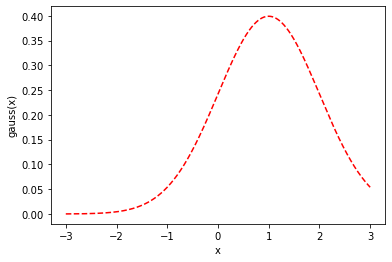

In [25]:
@vectorize([float32(float32)], target='parallel', fastmath=True)

def gauss(x):
    mu = 1
    sigma  = 1
    return 1/(sigma*(2*np.pi)**(1/2))*np.exp(-((x-mu)/sigma)**2 /2)
    
x = np.linspace(-3, 3, 10000, dtype='float32')

plt.plot(x, gauss(x), "r--")
plt.xlabel("x")
plt.ylabel("gauss(x)")

gauss(x)

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

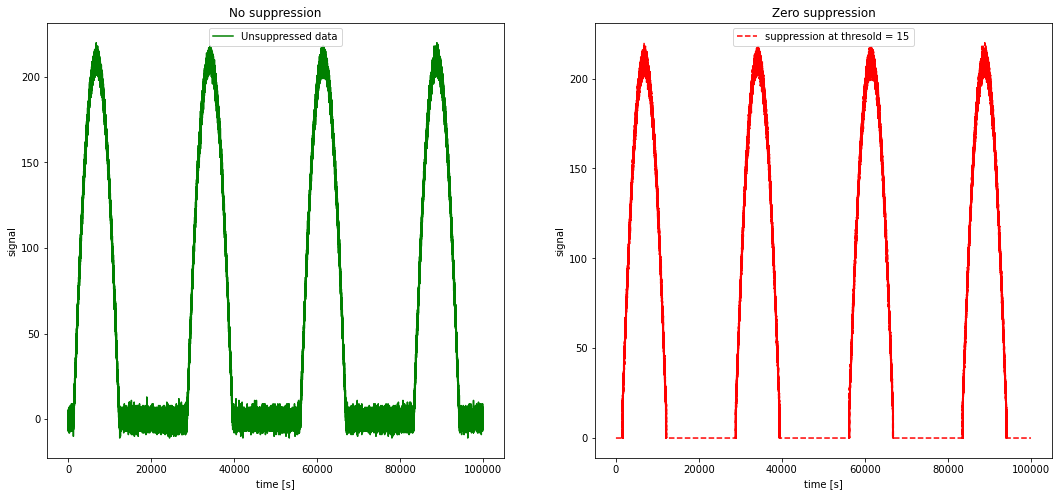

In [48]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

#put your code here
    
@vectorize([float32(float32)], target='parallel', fastmath=True)
def zero_suppr(data):
    if data > 15: 
        return data
    else: 
        return 0

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

axes[0].plot(data, "g", label = "Unsuppressed data")
axes[0].set_title('No suppression')
axes[0].set(xlabel = 'time [s]', ylabel = 'signal')
axes[0].legend(loc = "best")

axes[1].plot(zero_suppr(data), "r--", label = "suppression at thresold = 15")
axes[1].set_title('Zero suppression')
axes[1].set(xlabel = 'time [s]', ylabel = 'signal')
axes[1].legend(loc = "best")

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [71]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)
alpha = 0.3 
c = 0.1 

# CUDA kernel
@cuda.jit
def sigmoid_kernel(arr, x, y, alpha, c):
    row, col = cuda.grid(2)
    
    if row < arr.shape[0] and col < arr.shape[1]:
        arr[row][col] = np.tanh(alpha*np.dot(x[row],y[col])+c)

arr = np.zeros((len(X), len(Y)))

# Configure the blocks
threadsperblock = (3, 3) #ThreadsPerBlock must be a divisor of the data dimension: 1024/ 64 / 16 = 1
blockspergrid_x = int(math.ceil(X.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(Y.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

sigmoid_kernel[blockspergrid, threadsperblock](arr, X, Y, alpha, c)
print(arr)

[[0.38868842 0.43064635 0.31204941]
 [0.38380475 0.500961   0.36075357]
 [0.36217315 0.39725097 0.28678462]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [55]:
mat = np.random.rand(256,256,256)

@cuda.jit
def cos_3D(arr):
    x, y, z = cuda.grid(3)
        
    if x < arr.shape[0] and y < arr.shape[1] and z < arr.shape[2]:
        arr[x][y][z] = np.cos(arr[x][y][z])
        
cos_3D[blockspergrid, threadsperblock](matrix)

print(mat)

[[[0.79051687 0.3255013  0.50308299 ... 0.92523804 0.92548561 0.34085728]
  [0.06424933 0.68163364 0.64747519 ... 0.35076672 0.27450395 0.42337214]
  [0.10960778 0.90862363 0.55278978 ... 0.02122163 0.26546733 0.09705648]
  ...
  [0.21698849 0.5923642  0.20168424 ... 0.32215097 0.31630865 0.22814302]
  [0.17980134 0.87523519 0.05939945 ... 0.22071076 0.83128961 0.25331831]
  [0.39563017 0.7129769  0.55915253 ... 0.89066468 0.55536632 0.52397492]]

 [[0.63858476 0.40141937 0.55760941 ... 0.03440029 0.07247019 0.77051183]
  [0.54633443 0.3491731  0.96965457 ... 0.97918588 0.35230164 0.05764462]
  [0.04950254 0.01594765 0.66639567 ... 0.35039655 0.1794922  0.41548418]
  ...
  [0.7336177  0.08685221 0.73322261 ... 0.601988   0.50025272 0.2526749 ]
  [0.04056231 0.69002575 0.28579263 ... 0.8436702  0.69765207 0.04221142]
  [0.70894682 0.86947249 0.16453108 ... 0.93333008 0.61195023 0.71505537]]

 [[0.13787402 0.5867385  0.34014913 ... 0.69465013 0.43489154 0.6597308 ]
  [0.93550116 0.411058

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [56]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(0,10,24*12).reshape(24,12)
B = np.random.randint(0,10,12*22).reshape(12,22)
C = np.zeros(24*22).reshape(24,22)

# Configure the blocks
threadsperblock = (64, 16)
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

matmul[blockspergrid, threadsperblock](A, B, C)
print(C)

[[214. 167. 180. 285. 262. 295. 199. 184. 253. 208. 256. 319. 341. 245.
  261. 244. 147. 163. 241. 245. 153. 243.]
 [161. 205. 123. 278. 270. 246. 250. 184. 304. 231. 283. 272. 273. 231.
  206. 318. 219. 165. 244. 213. 201. 194.]
 [237. 196. 200. 304. 291. 255. 229. 215. 292. 305. 314. 350. 348. 219.
  265. 286. 184. 201. 201. 210. 140. 205.]
 [199.  96. 191. 227. 268. 236. 183. 176. 242. 216. 276. 261. 296. 242.
  230. 245. 192. 172. 223. 243. 182. 148.]
 [198. 241. 174. 261. 305. 262. 243. 179. 280. 237. 300. 269. 340. 268.
  253. 239. 190. 176. 262. 199. 138. 228.]
 [118. 135. 121. 191. 190. 165. 176. 131. 221. 155. 186. 207. 270. 180.
  190. 172. 151. 130. 193. 175. 119. 153.]
 [200. 209. 148. 277. 324. 272. 322. 236. 299. 237. 352. 306. 381. 326.
  252. 283. 224. 220. 329. 224. 154. 258.]
 [153. 113. 124. 186. 224. 122. 221. 196. 170. 188. 248. 205. 248. 219.
  185. 178. 138. 157. 188. 159. 107. 129.]
 [225. 191. 209. 253. 277. 294. 203. 185. 254. 212. 272. 307. 368. 241.
  278. 2